In [1]:
# %%
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import dash as go
import plotly.express as px

# Define season URLs
season_urls = {
    49: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=38",
    50: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=39",
    53: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=40",
    54: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=41",
    55: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=42",
    56: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=43",
    57: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=44",
    58: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=45",
    59: "https://strahovskaliga.cz/TymProfil/?TID=1882"  # current season
}

# Prepare to store match data
all_matches = []

# Function to get team players for a season
def get_team_players(soup):
    players = []
    players_table = next((table for table in soup.find_all("table", class_="table") if "Jméno" in [th.get_text() for th in table.find_all("th")]), None)
    if players_table:
        for row in players_table.find("tbody").find_all("tr"):
            cells = row.find_all("td")
            if len(cells) >= 2:
                players.append(cells[1].get_text(strip=True))
    return players

# Function to extract match details
def get_match_details(match_url, team_players, season):
    match_data = []
    match_response = requests.get(match_url)
    match_response.encoding = 'windows-1250'
    match_soup = BeautifulSoup(match_response.text, "html.parser")
    
    team_links = match_soup.find_all("a", href=re.compile(r"/TymProfil/\?TID=\d+"))
    if len(team_links) < 2:
        return match_data
    
    # Determine team and opponent IDs
    team1_id = re.search(r"TID=(\d+)", team_links[0]["href"]).group(1)
    team2_id = re.search(r"TID=(\d+)", team_links[1]["href"]).group(1)
    your_team_id, opponent_id = (team1_id, team2_id) if team1_id == "1882" else (team2_id, team1_id)

    date = match_soup.find("td").get_text(strip=True).split('-')[0].strip()
    goals = match_soup.find("h2", style="font-size: 40px;").get_text(strip=True)

    for team_div in match_soup.find_all("div", class_="pole"):
        player_table = team_div.find("table", class_="table-hover")
        if player_table:
            for row in player_table.find("tbody").find_all("tr"):
                cells = row.find_all("td")
                if len(cells) >= 3:
                    player_name = cells[1].get_text(strip=True)
                    player_goals = cells[2].get_text(strip=True) if cells[2].get_text(strip=True) else np.nan
                    if player_name in team_players:
                        match_data.append({"Player Name": player_name, "Opponent ID": opponent_id, "Date": date, "Goals": player_goals, "Season": season})
    return match_data

# Loop through each season to gather data
for season, url in season_urls.items():
    response = requests.get(url)
    response.encoding = 'windows-1250'
    soup = BeautifulSoup(response.text, "html.parser")
    
    team_players = get_team_players(soup)
    match_rows = soup.find_all("tr", {"title": "Detail Zapasu"})
    
    for row in match_rows:
        match_id = row.get("id")
        if match_id:
            match_url = f"https://strahovskaliga.cz/DetailZapasu/?MID={match_id}"
            all_matches.extend(get_match_details(match_url, team_players, season))
player_goals = pd.DataFrame(all_matches)

player_goals

,Player Name,Opponent ID,Date,Goals,Season
0,Jakub Hlídek,1870,14. 11. 2019,2,49
1,Vít Pazderník,1870,14. 11. 2019,1,49
2,Jakub Rosol,1870,14. 11. 2019,0,49
3,Jan Čapek,1870,14. 11. 2019,0,49
4,Filip Peloušek,1870,14. 11. 2019,0,49
...,...,...,...,...,...
531,Jan Čapek,1716,3. 10. 2024,0,59
532,Jiří Čapek,1716,3. 10. 2024,0,59
533,Jakub Hlídek,1716,3. 10. 2024,0,59
534,Jakub Čapek,1716,3. 10. 2024,0,59


In [13]:
# Fetch the page content
url = "https://strahovskaliga.cz/Liga/?LID=4"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract opponent IDs from player_goals
opponent_ids = player_goals['Opponent ID'].unique()

# Initialize list for opponent data
opponents = []

# Find all team links in the league page
team_links = soup.find_all('a', href=re.compile(r'TymProfil/\?TID=\d+'))

# Iterate over each link to extract team information
for link in team_links:
    href = link.get('href', '')
    team_id_match = re.search(r'TID=(\d+)', href)
    if team_id_match:
        team_id = team_id_match.group(1)
        # Only add teams that are in opponent_ids
        if team_id in opponent_ids:
            team_name = link.get_text(strip=True)
            opponents.append({'Opponent ID': team_id, 'Opponent Name': team_name})

# Convert to DataFrame
opponents_df = pd.DataFrame(opponents)

# Merge opponent data with player_goals
player_goals = player_goals.merge(opponents_df, on='Opponent ID', how='left')

player_goals



,Player Name,Opponent ID,Date,Goals,Season,Opponent Name
0,Jakub Hlídek,1870,14. 11. 2019,2,49,Dopravka United
1,Vít Pazderník,1870,14. 11. 2019,1,49,Dopravka United
2,Jakub Rosol,1870,14. 11. 2019,0,49,Dopravka United
3,Jan Čapek,1870,14. 11. 2019,0,49,Dopravka United
4,Filip Peloušek,1870,14. 11. 2019,0,49,Dopravka United
...,...,...,...,...,...,...
531,Jan Čapek,1716,3. 10. 2024,0,59,Psi
532,Jiří Čapek,1716,3. 10. 2024,0,59,Psi
533,Jakub Hlídek,1716,3. 10. 2024,0,59,Psi
534,Jakub Čapek,1716,3. 10. 2024,0,59,Psi


In [14]:
player_goals['Goals'] = pd.to_numeric(player_goals['Goals'], errors='coerce')
player_goals['Date'] = pd.to_datetime(player_goals['Date'], format='%d. %m. %Y')

# Modify the data to correct the goals for the specified players
player_goals.loc[((player_goals['Date'] == '14.11.2024') & (player_goals['Player Name'] == 'Martin Žlábek' )),'Goals'] = 1

player_goals.loc[((player_goals['Date'] == '14.11.2024') & (player_goals['Player Name'] == 'Jiří Čapek' )),'Goals'] = 0

player_goals.loc[((player_goals['Date'] == '14.11.2024') & (player_goals['Player Name'] == 'Jiří Čapek' )),'Goals'] = 0

In [15]:
# Calculate total goals per player per season
season_player_totals = player_goals.groupby(['Season', 'Player Name'])['Goals'].sum().reset_index()

# Identify top player for each season
top_players_per_season = season_player_totals.loc[season_player_totals.groupby('Season')['Goals'].idxmax()]

# Filter out rows with no data in the 'Goals' column
top_players_per_season = top_players_per_season[top_players_per_season['Goals'] > 0]

# Sort the 'Season' column and convert it to a string to avoid numerical gaps
top_players_per_season['Season'] = top_players_per_season['Season'].astype(str)
unique_seasons = top_players_per_season['Season'].unique()

# Create the bar chart
fig = px.bar(
    top_players_per_season,
    x='Season',
    y='Goals',
    color='Player Name',
    text='Player Name',
    title='Top Player by Season',
    category_orders={'Season': unique_seasons}  # Ensure only these seasons are shown in the specified order
)

# Update the plot to customize text and x-axis
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False, showlegend=False)

# Show the plot
fig.show()

In [16]:
# Calculate the sum of goals per player per season
season_player_stats = player_goals.groupby(['Player Name', 'Season'])['Goals'].sum().reset_index()

# Calculate the mean and standard deviation of goals per season for each player
season_player_avg_std = season_player_stats.groupby('Player Name')['Goals'].agg(['mean', 'std']).reset_index().sort_values(by='mean', ascending=False)
season_player_avg_std.columns = ['Player Name', 'Average Goals Per Season', 'STD Goals Per Season']

fig = px.scatter(
    season_player_avg_std,
    y='Average Goals Per Season',
    x='Player Name',
    error_y='STD Goals Per Season',
    title='Average Goals Per Season by Player with Standard Deviation'
)
fig.show()


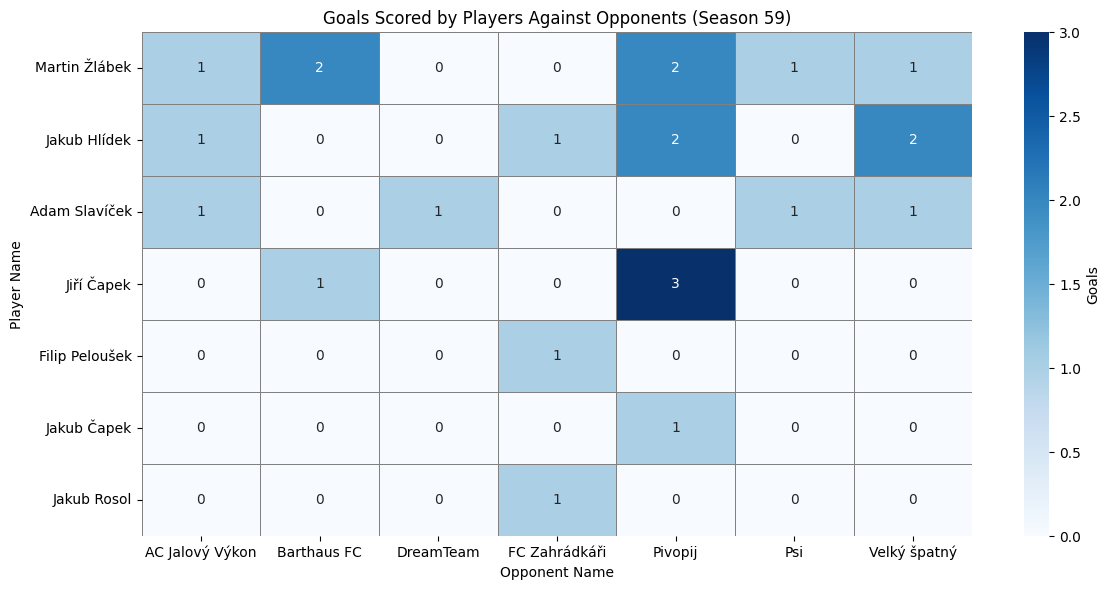

In [17]:
# Filter data for 'Season' == 59
season_59_data = player_goals[player_goals['Season'] == 59]

# Sort data by the 'Date' column
season_59_data = season_59_data.sort_values(by='Date')

# Create a pivot table for the filtered and sorted data
heatmap_data = season_59_data.pivot_table(values='Goals', index='Player Name', columns='Opponent Name', aggfunc='sum', fill_value=0)

# Remove rows where all values are zero
heatmap_data = heatmap_data.loc[~(heatmap_data == 0).all(axis=1)]

# Order rows by the total number of goals scored (descending)
heatmap_data['Total Goals'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values(by='Total Goals', ascending=False)
heatmap_data = heatmap_data.drop(columns='Total Goals')  # Remove the temporary 'Total Goals' column

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Goals'})
plt.title('Goals Scored by Players Against Opponents (Season 59)')
plt.xlabel('Opponent Name')
plt.ylabel('Player Name')
plt.tight_layout()
plt.show()
